<h1 align="center" style="color:#00529b;">Hate Speech Detection Using LSTM - Data Analysis & Prediction </h1>
<h2 align="center" style="color:#00529b;">ECE - École d'Ingénieurs Campus Lyon</h2>
<h3 align="center" style="color:#007acc;">Projet Machine Learning & Deep Learning, A.A. 2023/2024</h3>

---

## Project Objective

1. Utilize a dataset comprising Twitter data for the purpose of hate-speech detection.
   
2. Implement classification of text into categories: hate-speech, offensive language, and neither.
   
3. Highlight the significance of the dataset's content, which may include text classified as racist, sexist, homophobic, or generally offensive, crucial for the study's context.




In [1]:
import os
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  Chargement du jeu de données </div> 

In [2]:
def load_data(file_path):
    """
    Charge les données à partir du fichier CSV spécifié.
    
    Args:
    file_path (str): Chemin du fichier CSV.
    
    Returns:
    pandas.DataFrame: Les données chargées à partir du fichier CSV.
    """
    data = pd.read_csv(file_path, sep=',')
    # Renommer la première colonne en "id"
    data = data.rename(columns={"Unnamed: 0": "id"})
    data.reset_index(drop=True, inplace=True)
    data.sort_index(axis=0, inplace=True)
    return data

# Chemin vers le fichier CSV
path = "/Users/surelmanda/Downloads/AirGUARD/NLP-Hate-Speech-Detection/train.csv"

# Charger les données à partir du fichier spécifié
data = load_data(path)

# Créer un dictionnaire de correspondance pour les étiquettes de classe
class_labels = {
    0: 'hate speech',
    1: 'offensive language',
    2: 'neither'
}

# Ajouter une colonne de sentiment en remplaçant les valeurs de la colonne 'class' par les libellés correspondants
data['sentiment'] = data['class'].replace(class_labels)

# Afficher la forme de l'ensemble de données
print("Les données en entrée ont {} lignes et {} colonnes".format(data.shape[0], data.shape[1]))

# Afficher quelque lignes de l'ensemble de données:
display(data.head())

Les données en entrée ont 24783 lignes et 8 colonnes


,id,count,hate_speech,offensive_language,neither,class,tweet,sentiment
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive language
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive language
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive language
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive language


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;"> Analyse du dataset </div> 

In [3]:
def resume_inspection_colonnes(data_frame):
    """
    Une fonction utilitaire qui fournit un résumé plus complet des colonnes du dataframe
    que les méthodes intégrées df.info() et df.describe().
    """
    
    total_lignes = len(data_frame)
    resume = pd.DataFrame({
        'Total Lignes': [total_lignes] * data_frame.shape[1],  # Nombre total de lignes dans le dataframe
        'Lignes avec Valeurs Manquantes': data_frame.isnull().sum(),  # Nombre de lignes avec des valeurs manquantes
        'Toutes les Valeurs Uniques': data_frame.nunique() == total_lignes,  # Vérifie si toutes les valeurs sont uniques dans chaque colonne
        'Cardinalité': data_frame.nunique(),  # Nombre de valeurs uniques dans chaque colonne
        'Contient des Valeurs Null': data_frame.isna().any(),  # Indique si la colonne contient des valeurs nulles
        'Pourcentage de Null': round((data_frame.isnull().sum() / total_lignes) * 100, 2),  # Pourcentage de valeurs nulles par rapport au total des lignes
        'Types de Données': data_frame.dtypes,  # Types de données de chaque colonne
        'Spécimens': data_frame.sample(2).T.values.tolist()  # Échantillons aléatoires de 5 lignes pour donner un aperçu des données
    })

    return resume


In [4]:
resultat_summary = resume_inspection_colonnes(data)
display(resultat_summary)

,Total Lignes,Lignes avec Valeurs Manquantes,Toutes les Valeurs Uniques,Cardinalité,Contient des Valeurs Null,Pourcentage de Null,Types de Données,Spécimens
id,24783,0,True,24783,False,0.0,int64,"[18635, 15500]"
count,24783,0,False,5,False,0.0,int64,"[3, 3]"
hate_speech,24783,0,False,8,False,0.0,int64,"[0, 0]"
offensive_language,24783,0,False,10,False,0.0,int64,"[3, 3]"
neither,24783,0,False,10,False,0.0,int64,"[0, 0]"
class,24783,0,False,3,False,0.0,int64,"[1, 1]"
tweet,24783,0,True,24783,False,0.0,object,[RT @ZitlalyL: @Vic_Manzan0 just like you&#128...
sentiment,24783,0,False,3,False,0.0,object,"[offensive language, offensive language]"


In [5]:
def visualiser_sentiments(dataset):
    # Calculer les pourcentages de chaque valeur dans la colonne 'sentiment'
    pourcentage_sentiment = dataset['class'].value_counts(normalize=True) * 100

    # Créer un DataFrame pour la visualisation
    data_pie = pd.DataFrame({
        'Sentiment': pourcentage_sentiment.index,
        'Pourcentage': pourcentage_sentiment.values
    })

    # Définir une palette de couleurs
    colors = px.colors.qualitative.Plotly

    # Créer les sous-tracés
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'bar'}]], subplot_titles=['Diagramme circulaire', 'Histogramme'])

    # Ajouter le diagramme circulaire
    fig.add_trace(go.Pie(labels=data_pie['Sentiment'], values=data_pie['Pourcentage'], name='', marker=dict(colors=colors)), row=1, col=1)

    # Ajouter l'histogramme
    fig.add_trace(go.Bar(x=data_pie['Sentiment'], y=data_pie['Pourcentage'], name='', marker=dict(color=colors)), row=1, col=2)

    # Mettre en forme la disposition des sous-tracés
    fig.update_layout(title='Pourcentage des sentiments (colonne cible)')

    # Afficher la figure
    fig.show()

# Utilisation de la fonction avec votre dataset
visualiser_sentiments(data)


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  preprocess train dataset tweet </div> 

In [6]:
import re
import nltk

def text_preprocessing(tweet):
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    word_to_remove    = "rt"
    emojiPattern      = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", re.UNICODE)
    
    # Make text lowercase, remove text in square brackets, remove links, remove punctuation
    # and remove words containing numbers.
    tweet = tweet.lower()
    # Replace all URLs with 'URL'-- >''
    tweet = re.sub(urlPattern,'',tweet)
    # Remove emojis.
    tweet = emojiPattern.sub(r'', tweet)
    # Replace @USERNAME to 'USER'.-->''
    tweet = re.sub(userPattern,'', tweet)        
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    # Remove words containing only numbers
    tweet = re.sub(r'\b\d+\b', '', tweet)
    # Replace rt --> ''
    tweet = re.sub(word_to_remove,'', tweet)   
    
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokenized_text = tokenizer.tokenize(tweet)
    # Combined text 
    combined_text = ' '.join(tokenized_text)
    return combined_text


In [7]:
# preprocess train dataset
data['clean_tweet'] = data['tweet'].apply(text_preprocessing)
data['Num_words_text'] = data['clean_tweet'].apply(lambda x:len(str(x).split())) 
# Afficher les premières lignes pour vérifier
display(data.head())

,id,count,hate_speech,offensive_language,neither,class,tweet,sentiment,clean_tweet,Num_words_text
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither,as a woman you shouldn t complain about cleani...,23
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive language,boy dats cold tyga dwn bad for cuffin dat hoe ...,14
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive language,dawg you ever fuck a bitch and she sta to cry ...,16
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive language,she look like a tranny,5
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive language,the shit you hear about me might be true or it...,22


In [8]:
# Liste des colonnes à supprimer
columns_to_drop = ['id', 'count', 'hate_speech', 'offensive_language', 'neither', 'Num_words_text','tweet']

# Supprimer les colonnes spécifiées
data.drop(columns=columns_to_drop, inplace=True)

# Afficher les premières lignes pour vérifier
display(data.head())

,class,sentiment,clean_tweet
0,2,neither,as a woman you shouldn t complain about cleani...
1,1,offensive language,boy dats cold tyga dwn bad for cuffin dat hoe ...
2,1,offensive language,dawg you ever fuck a bitch and she sta to cry ...
3,1,offensive language,she look like a tranny
4,1,offensive language,the shit you hear about me might be true or it...


In [9]:
# Définir le seuil de test
threshold_test = 0.25

# Mélanger aléatoirement les données
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Diviser les données en ensembles de formation et de test
train_data, test_data = train_test_split(data_shuffled, test_size=threshold_test, random_state=42)

# Réinitialiser les index
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Afficher les premières lignes des ensembles de formation et de test pour vérification
print("Train Data:")
print(f"Dimensions of Train Data: {train_data.shape}")
display(train_data.head())

print("\nTest Data:")
print(f"Dimensions of Test Data: {test_data.shape}")
display(test_data.head())

Train Data:
Dimensions of Train Data: (18587, 3)


,class,sentiment,clean_tweet
0,1,offensive language,smfh boy you sound just like them hoes idk why...
1,1,offensive language,uh oh control yo bitch if you don t want her i...
2,1,offensive language,destroying a team that talked trash before the...
3,1,offensive language,be a pussy as in cat
4,2,neither,alabama is overrated this yr the last weeks ha...



Test Data:
Dimensions of Test Data: (6196, 3)


,class,sentiment,clean_tweet
0,1,offensive language,dr gero made android to destroy da world das s...
1,1,offensive language,a bitch can t resist a nugga with a fresh cut ...
2,1,offensive language,you a bitch dennis
3,1,offensive language,you a hoe if you like gettin drunk
4,1,offensive language,it s gotten to the point where i literally don...


In [10]:
def print_class_proportions(data, dataset_name):
    print(f'================== {dataset_name} ================')
    display(data['sentiment'].value_counts().reset_index())
    print(f"Dimensions of {dataset_name} : {test_data.shape}")
    print('=============================================')

# Utilisation de la fonction pour les données d'entraînement
print_class_proportions(train_data, "Train Data")

# Utilisation de la fonction pour les données de test
print_class_proportions(test_data, "Test Data")

================== Train Data ================


,sentiment,count
0,offensive language,14393
1,neither,3103
2,hate speech,1091


Dimensions of Train Data : (6196, 3)
================== Test Data ================


,sentiment,count
0,offensive language,4797
1,neither,1060
2,hate speech,339


Dimensions of Test Data : (6196, 3)


In [11]:
def split_train_test_data(X_original, y_original, test_size=0.12, random_state=None):
    # Divise les données en ensembles d'entraînement et de test avec stratification et mélange
    X_train, X_valid, y_train, y_valid = train_test_split(X_original, y_original, test_size=test_size, 
                                                        stratify=y_original, shuffle=True, random_state=random_state)
    
    return X_train, X_valid, y_train, y_valid

def print_dataset_info(X_train, X_valid, y_train, y_valid):
    # Print the dimensions of X_train, X_test, y_train, y_test
    print("")
    print(f"Dimensions of X_train: {X_train.shape}")
    print(f"Dimensions of X_valid: {X_valid.shape}")
    print(f"Dimensions of y_train: {y_train.shape}")
    print(f"Dimensions of y_valid: {y_valid.shape}")
    print("")

    # Print the number of unique classes in y_train and y_test
    num_classes_train = len(np.unique(y_train))
    num_classes_test = len(np.unique(y_valid))
    print(f"Number of unique classes in y_train: {num_classes_train}")
    print(f"Number of unique classes in y_valid: {num_classes_test}")

    print("")

    # Print the number of instances per class in y_train and y_test
    for class_label in np.unique(y_train):
        instances_train = np.sum(y_train == class_label)
        instances_test = np.sum(y_valid == class_label)
        print(f"Class {class_label}: Train instances - {instances_train}, Test instances - {instances_test}")


In [12]:
# Setting threshold values for evaluation and test datasets
threshold_test = 0.20

# Assuming 'sentiment' is the column you want to predict
X = train_data['clean_tweet']
y = train_data['class']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_valid, y_train, y_valid = split_train_test_data(X, y, test_size=threshold_test, random_state=424)

# Vérifier les dimensions des ensembles d'entraînement et de test
print_dataset_info(X_train, X_valid, y_train, y_valid)


Dimensions of X_train: (14869,)
Dimensions of X_valid: (3718,)
Dimensions of y_train: (14869,)
Dimensions of y_valid: (3718,)

Number of unique classes in y_train: 3
Number of unique classes in y_valid: 3

Class 0: Train instances - 873, Test instances - 218
Class 1: Train instances - 11514, Test instances - 2879
Class 2: Train instances - 2482, Test instances - 621


In [13]:
# Convertir les DataFrames en listes
X_train, X_valid = X_train.values.tolist(), X_valid.values.tolist()
y_train, y_valid = y_train.values.tolist(), y_valid.values.tolist()

In [14]:
max([len(x) for x in train_data['clean_tweet'].values.tolist()])

143

In [15]:
max([len(x) for x in test_data['clean_tweet'].values.tolist()])

141

In [16]:
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Nombre de mots à considérer
num_words = 50000

# Créer un tokenizer et l'adapter sur les données d'entraînement
tokenizer = Tokenizer(num_words=num_words, oov_token="unk")
tokenizer.fit_on_texts(X_train)

# Convertir les phrases en séquences de nombres
x_train = tokenizer.texts_to_sequences(X_train)
x_valid = tokenizer.texts_to_sequences(X_valid)
x_test =  tokenizer.texts_to_sequences(test_data['clean_tweet'].values.tolist())

# Taille maximale des séquences (ajuster selon les besoins)
maxlen = 144 # max([len(x) for x in train_data['clean_tweet'].values.tolist()])

# Remplissage des séquences pour qu'elles aient toutes la même longueur
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

# Conversion des étiquettes en tableaux numpy
train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['class'].tolist())

# Affichage de la taille et de la distribution des classes dans les données d'entraînement
print('Taille des données d\'entraînement :', len(x_train))
print('Distribution des classes dans les données d\'entraînement :', Counter(train_labels))

# Affichage de la taille et de la distribution des classes dans les données de validation
print('Taille des données de validation :', len(x_valid))
print('Distribution des classes dans les données de validation :', Counter(valid_labels))

# Affichage de la taille et de la distribution des classes dans les données de test
print('Taille des données de test :', len(x_test))
print('Distribution des classes dans les données de test :', Counter(test_labels))

# Préparation des datasets TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, test_labels))


Taille des données d'entraînement : 14869
Distribution des classes dans les données d'entraînement : Counter({1: 11514, 2: 2482, 0: 873})
Taille des données de validation : 3718
Distribution des classes dans les données de validation : Counter({1: 2879, 2: 621, 0: 218})
Taille des données de test : 6196
Distribution des classes dans les données de test : Counter({1: 4797, 2: 1060, 0: 339})


In [17]:
# Affichage des valeurs et des labels dans les datasets
count = 0
print('========== Train dataset ===============')
for value, label in train_ds:
    count += 1
    print("Valeur :", value)
    print("Label :", label)
    if count == 1:
        break

count = 0
print('\n========== Validation dataset ========')
for value, label in valid_ds:
    count += 1
    print("Valeur :", value)
    print("Label :", label)
    if count == 1:
        break

count = 0
print('\n========== Test dataset ==============')
for value, label in test_ds:
    count += 1
    print("Valeur :", value)
    print("Label :", label)
    if count == 1:
        break

========== Train dataset ===============
Valeur : tf.Tensor(
[   2  113  194   27 2246    7  480   65  176    2  113   34  687   65
   17   28   11  913    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(144,), dtype=int32)
Label : tf.Tensor(1, shape=(), dtype=int64)

========== Validation dataset ========
Valeur : tf.Tensor(
[ 151  972  107   59 1184  100   78    3 1110  148 1110   19  197   14
 135

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, classification_report

In [200]:
# Modèle de Deep Learning avec TensorFlow
max_features = 50000
embedding_dim = 16
sequence_length = maxlen

# Création du modèle avec un nom spécifié
model = Sequential(name="LSTM_hate_Tweet_classifier")
model.add(Embedding(max_features + 1, embedding_dim, input_length=sequence_length,embeddings_regularizer=regularizers.l2(0.005))) 
model.add(Dropout(0.4))

model.add(LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,kernel_regularizer=regularizers.l2(0.005), 
               bias_regularizer=regularizers.l2(0.005)))

model.add(Flatten())

model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))
model.add(Dropout(0.4))

model.add(Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

model.summary()

# Utilisation de l'optimiseur legacy pour Macs M1/M2
model.compile(loss=BinaryCrossentropy(), optimizer=legacy.Adam(1e-3), metrics=[BinaryAccuracy(name='accuracy')])

Model: "LSTM_hate_Tweet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 144, 16)           800016    
                                                                 
 dropout_49 (Dropout)        (None, 144, 16)           0         
                                                                 
 lstm_14 (LSTM)              (None, 144, 16)           2112      
                                                                 
 flatten_14 (Flatten)        (None, 2304)              0         
                                                                 
 dense_49 (Dense)            (None, 512)               1180160   
                                                                 
 dropout_50 (Dropout)        (None, 512)               0         
                                                                 
 dense_50 (Dense)            (None, 8)  

In [202]:
# Modèle de Deep Learning avec TensorFlow
max_features = 50000
embedding_dim = 16
sequence_length = maxlen

# Création du modèle avec un nom spécifié
model = Sequential(name="LSTM_hate_Tweet_classifier")
model.add(Embedding(max_features + 1, embedding_dim, input_length=sequence_length,embeddings_regularizer=regularizers.l2(0.005))) 
model.add(Dropout(0.04))

model.add(Bidirectional(LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,kernel_regularizer=regularizers.l2(0.005),
                             bias_regularizer=regularizers.l2(0.005))))

model.add(Flatten())

model.add(Dense(512, activation='tanh',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))
# model.add(Dropout(0.6))

model.add(Dense(250, activation='tanh',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))
# model.add(Dropout(0.6))

model.add(Dense(8, activation='tanh',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))
# model.add(Dropout(0.001))

model.add(Dense(1, activation='sigmoid'))

model.summary()

# Utilisation de l'optimiseur legacy pour Macs M1/M2
model.compile(loss=BinaryCrossentropy(), optimizer=legacy.Adam(1e-3), metrics=[BinaryAccuracy(name='accuracy')])

Model: "LSTM_hate_Tweet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 144, 16)           800016    
                                                                 
 dropout_52 (Dropout)        (None, 144, 16)           0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 144, 32)           4224      
 onal)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 4608)              0         
                                                                 
 dense_52 (Dense)            (None, 512)               2359808   
                                                                 
 dense_53 (Dense)            (None, 250)               128250    
                                        

In [33]:
# Modèle de Deep Learning avec TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras import regularizers

# Définition des paramètres du modèle
max_features = 50000
embedding_dim = 16
sequence_length = maxlen

# Arguments pour la couche Embedding
embedding_args = {
    'input_dim': max_features + 1,      # Taille du vocabulaire
    'output_dim': embedding_dim,        # Dimension de l'embedding
    'embeddings_regularizer': regularizers.l2(0.005),
    'input_length': sequence_length    # Longueur de la séquence d'entrée
}

# Création du modèle avec un nom spécifié
model = Sequential(name="LSTM_for_hate_Tweet_classifier")
model.add(Embedding(**embedding_args))  # Utilisation des arguments de la couche Embedding
model.add(Bidirectional(LSTM(units=150,dropout=0.2,recurrent_dropout=0.2, 
                             return_sequences=True,kernel_regularizer=regularizers.l2(0.005),
                             bias_regularizer=regularizers.l2(0.005))))
model.add(Flatten())
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))

model.add(Dense(20, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))
model.add(Dense(units=3, activation='softmax'))  # 3 classes à prédire

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()


Model: "LSTM_for_hate_Tweet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 144, 16)           800016    
                                                                 
 bidirectional_6 (Bidirecti  (None, 144, 300)          200400    
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 43200)             0         
                                                                 
 dense_19 (Dense)            (None, 64)                2764864   
                                                                 
 dense_20 (Dense)            (None, 20)                1300      
                                                                 
 dense_21 (Dense)            (None, 3)                 63        
                                    

In [34]:
epochs = 10
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(5000).batch(1024), epochs= epochs, validation_data=valid_ds.batch(1024), verbose=1)

Epoch 1/10


15/15 [==============================] - 49s 3s/step - loss: 4.8321 - accuracy: 0.7333 - val_loss: 3.6228 - val_accuracy: 0.7743
Epoch 2/10
15/15 [==============================] - 44s 3s/step - loss: 3.0735 - accuracy: 0.7744 - val_loss: 2.5905 - val_accuracy: 0.7743
Epoch 3/10
15/15 [==============================] - 212s 15s/step - loss: 2.3773 - accuracy: 0.7744 - val_loss: 2.1734 - val_accuracy: 0.7743
Epoch 4/10
15/15 [==============================] - 51s 3s/step - loss: 2.0315 - accuracy: 0.8211 - val_loss: 1.9260 - val_accuracy: 0.8529
Epoch 5/10
15/15 [==============================] - 49s 3s/step - loss: 1.8481 - accuracy: 0.8761 - val_loss: 1.8084 - val_accuracy: 0.8741
Epoch 6/10
15/15 [==============================] - 1328s 95s/step - loss: 1.7361 - accuracy: 0.8976 - val_loss: 1.7494 - val_accuracy: 0.8731
Epoch 7/10
15/15 [==============================] - 48s 3s/step - loss: 1.6409 - accuracy: 0.9133 - val_loss: 1.6798 - val_accuracy: 0.8849
Epoch 8/10
15/15 [========

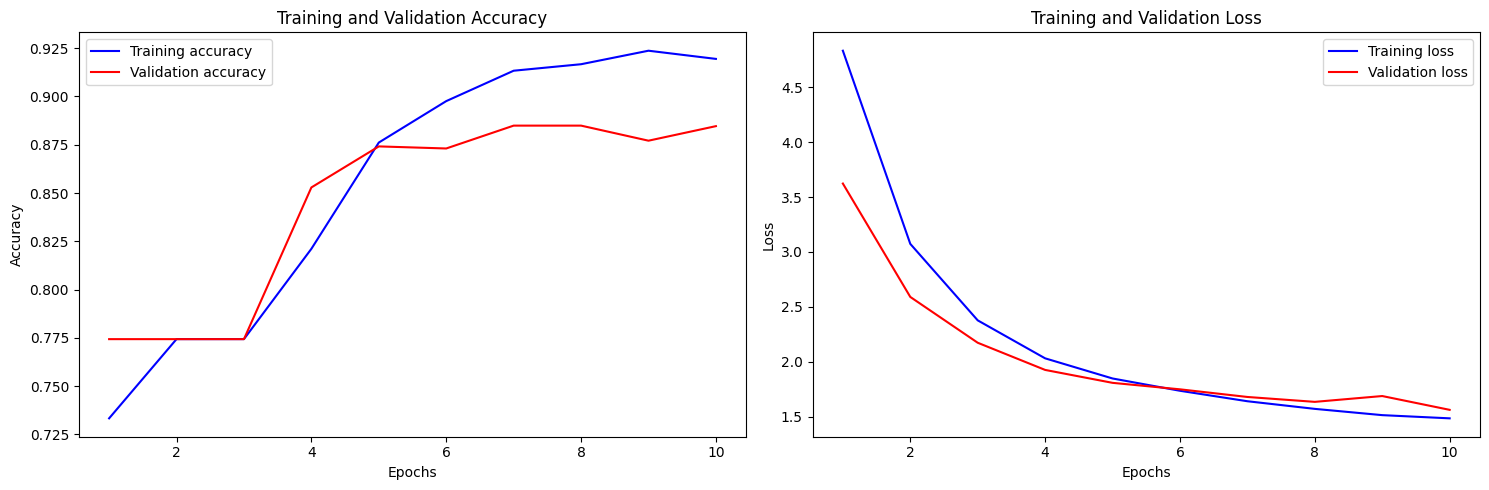

In [35]:
# Get accuracy and loss history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plot accuracy and loss in subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axs[0].plot(epochs, accuracy, 'b', label='Training accuracy')
axs[0].plot(epochs, val_accuracy, 'r', label='Validation accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(epochs, loss, 'b', label='Training loss')
axs[1].plot(epochs, val_loss, 'r', label='Validation loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


In [208]:
# Build a Sequential model with bidirectional LSTM

# Création du modèle avec un nom spécifié
model = Sequential(name="LSTM_for_hate_Tweet_classifier")
model.add(Embedding(input_dim=max_features, output_dim=16, input_length=sequence_length))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 144, 16)           800000    
                                                                 
 bidirectional_11 (Bidirect  (None, 128)               41472     
 ional)                                                          
                                                                 
 dense_58 (Dense)            (None, 3)                 387       
                                                                 
Total params: 841859 (3.21 MB)
Trainable params: 841859 (3.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [209]:
epochs = 10
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(5000).batch(1024), epochs= epochs, validation_data=valid_ds.batch(1024), verbose=1)

Epoch 1/10


15/15 [==============================] - 15s 826ms/step - loss: 0.9168 - accuracy: 0.7744 - val_loss: 0.7185 - val_accuracy: 0.7743
Epoch 2/10
15/15 [==============================] - 10s 680ms/step - loss: 0.6747 - accuracy: 0.7744 - val_loss: 0.6594 - val_accuracy: 0.7743
Epoch 3/10
15/15 [==============================] - 10s 683ms/step - loss: 0.6559 - accuracy: 0.7744 - val_loss: 0.6533 - val_accuracy: 0.7743
Epoch 4/10
15/15 [==============================] - 11s 716ms/step - loss: 0.6425 - accuracy: 0.7744 - val_loss: 0.6378 - val_accuracy: 0.7743
Epoch 5/10
15/15 [==============================] - 10s 689ms/step - loss: 0.6103 - accuracy: 0.7744 - val_loss: 0.6001 - val_accuracy: 0.7743
Epoch 6/10
15/15 [==============================] - 10s 681ms/step - loss: 0.5471 - accuracy: 0.7823 - val_loss: 0.5066 - val_accuracy: 0.7969
Epoch 7/10
15/15 [==============================] - 10s 689ms/step - loss: 0.4466 - accuracy: 0.8374 - val_loss: 0.4816 - val_accuracy: 0.8133
Epoch 8/10

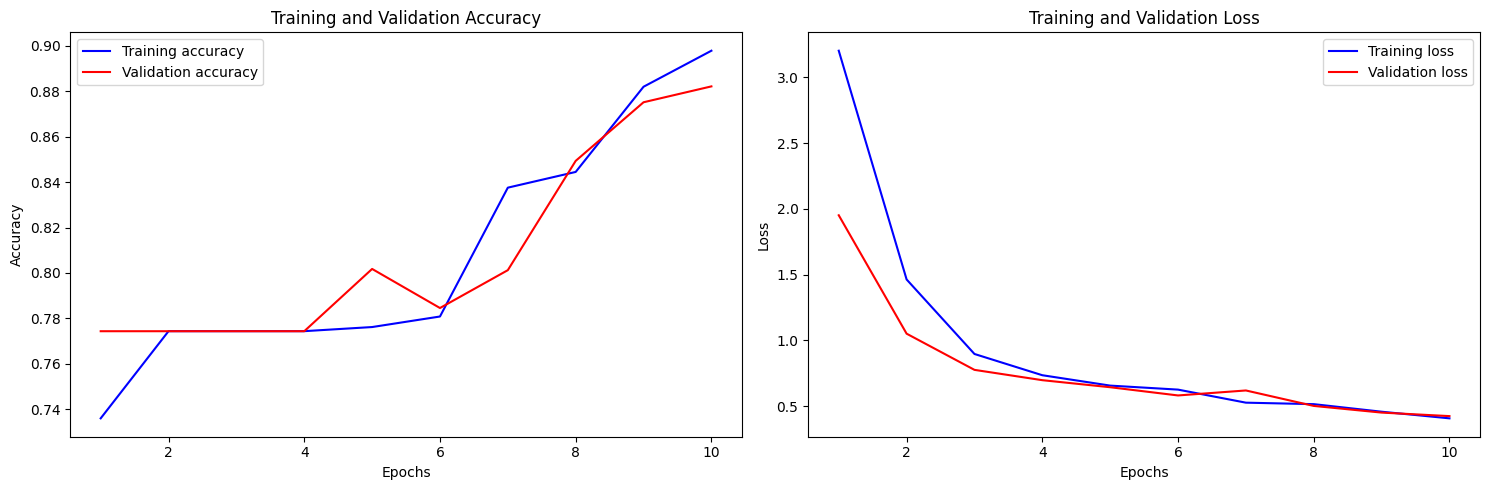

In [214]:
# Get accuracy and loss history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plot accuracy and loss in subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axs[0].plot(epochs, accuracy, 'b', label='Training accuracy')
axs[0].plot(epochs, val_accuracy, 'r', label='Validation accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(epochs, loss, 'b', label='Training loss')
axs[1].plot(epochs, val_loss, 'r', label='Validation loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


In [14]:
#make predictions on validation dataset
valid_predict= model.predict(x_valid)
print(valid_predict[:10])

[[1.4268547e-01]
 [9.7826517e-01]
 [5.8067143e-03]
 [2.8772950e-03]
 [3.6336260e-05]
 [1.2026131e-03]
 [9.8628443e-01]
 [4.0706992e-04]
 [1.5170112e-01]
 [3.8477778e-04]]


In [15]:
#model's metrics on test dataset
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


#Generate predictions for all samples
predictions = model.predict(x_test)

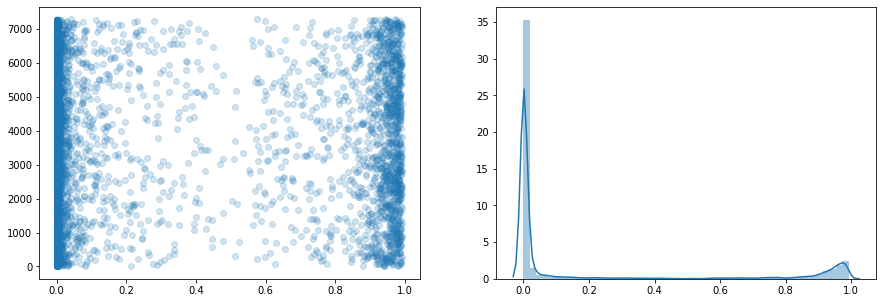

In [16]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,range(0,len(predictions)),alpha=0.2)
ax2=sns.distplot(predictions)

#### A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied

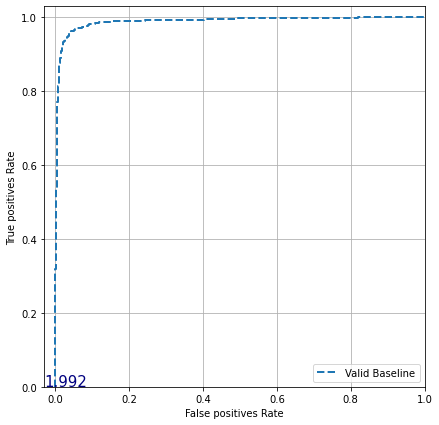

In [17]:
#decide the cutoff for classifying the predicted probabilities as 1 or 0
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

mpl.rcParams['figure.figsize'] = (7,7)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [18]:
cutoff=0.86
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= cutoff),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < cutoff),0,test_data.pred_sentiment)

labels = [0, 1]
print(classification_report(test_data['label'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5959
           1       0.95      0.82      0.88      1331

    accuracy                           0.96      7290
   macro avg       0.95      0.91      0.93      7290
weighted avg       0.96      0.96      0.96      7290



## TESTING MODEL ON THE TEST DATASET PROVIDED

In [19]:
final_test=pd.read_csv("test.csv")

ftest=final_test.copy()
ftest.drop(columns=['id'],axis=1,inplace=True)

ftest['tweet'] = ftest['tweet'].apply(remove_emoji)
ftest['tweet'] = ftest['tweet'].apply(clean_text)

f_test  = np.array( tokenizer.texts_to_sequences(ftest['tweet'].tolist()) )
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

display((x_test))
display((f_test))

array([[  209,     5,     1, ...,     0,     0,     0],
       [    2,    26,    68, ...,     0,     0,     0],
       [28298,     0,     0, ...,     0,     0,     0],
       ...,
       [   14,   502,     2, ...,     0,     0,     0],
       [    2,  2802,   605, ...,     0,     0,     0],
       [    2,  1659,     4, ...,     0,     0,     0]])

array([[10037,     1,  4900, ...,     0,     0,     0],
       [    2,    65, 10688, ...,     0,     0,     0],
       [  449,   761,   773, ...,     0,     0,     0],
       ...,
       [    9,    34,   356, ...,     0,     0,     0],
       [  364,   712,   126, ...,     0,     0,     0],
       [  258,  1042,  7030, ...,     0,     0,     0]])

In [20]:
#predict on actual test data
predictions = model.predict(f_test)

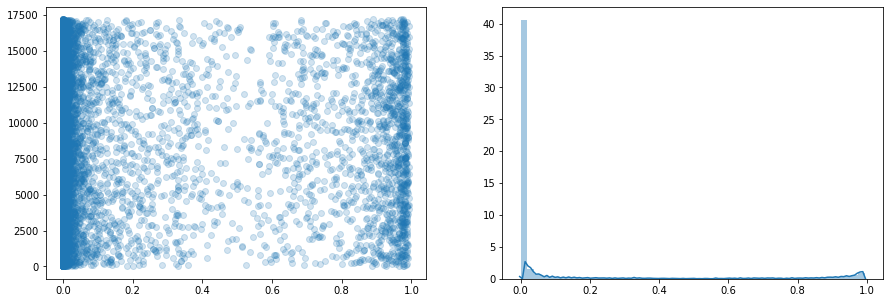

In [21]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,ftest.index,alpha=0.2)
ax2=sns.distplot(predictions)

In [22]:
#mapping prediction to 1 or 0
ftest['pred_sentiment']= predictions
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment >= cutoff),1,ftest.pred_sentiment)
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment < cutoff),0,ftest.pred_sentiment)

#processed tweets categorized as hate speech
pd.set_option('display.max_colwidth', None)
ftest[ftest['pred_sentiment']==1]

,tweet,pred_sentiment
1,user white supremacists want everyone birdsâ movie hereâs,1.0
19,thought factory neutrality right wing fascism politics media brexit trump leadership,1.0
26,chick gets fucked hottest naked lady,1.0
33,suppo taiji fisherman bullying racism tweet4taiji thecove seashepherd,1.0
42,user user trumps invested billions into saudi empowers people funding isis trumpsahypocrite,1.0
...,...,...
17148,grew fucked upð¤ fucked upð¥ believing better place fucking upð© âï¸,1.0
17176,user user most racist ever,1.0
17188,black professor demonizes proposes nazi style confiscation white assets like 1930s germany breaking,1.0
17192,thought factory leftright polarisation trump uselections2016 leadership politics brexit,1.0


In [23]:
#actual tweets categorized as hate speech
final_test.iloc[ftest[ftest['pred_sentiment']==1].index]

,id,tweet
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
19,31982,thought factory: bbc neutrality on right wing fascism #politics #media #blm #brexit #trump #leadership &gt;3
26,31989,chick gets fucked hottest naked lady
33,31996,suppo the #taiji fisherman! no bullying! no racism! #tweet4taiji #thecove #seashepherd
42,32005,@user @user trumps invested billions into saudi. he empowers the people funding isis. #trumpsahypocrite
...,...,...
17148,49111,we grew up fucked upð¤ its fucked upð¥ i'm believing you in a better place but it's fucking me upð© Ã¨ âï¸
17176,49139,@user @user are the most racist pay ever!!!!!
17188,49151,"black professor demonizes, proposes nazi style confiscation of ""white"" assets; like 1930's germany #breaking"
17192,49155,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3
